# qa-nlp
Question answering neural model based on the SQuAD dataset.

Authors:
- Lorenzo Mario Amorosa
- Andrea Espis
- Mattia Orlandi
- Giacomo Pinardi

## 0. Environment setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Library to read json
import json

# Numeric and data manipulation tools
import pandas as pd
import numpy as np
import random

# Deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Natural language tools
import nltk
from nltk.tokenize import TreebankWordTokenizer
import gensim
import gensim.downloader as gloader

# Other tools
from tqdm.notebook import tqdm
from collections import OrderedDict, Counter
from time import time
from itertools import zip_longest

# automatic mixed precision training:
from torch.cuda.amp import autocast 
from torch.cuda.amp import GradScaler

# Type hint
from typing import Optional, Callable, Tuple, Dict, List, Union

nltk.download('punkt')
nltk.download('stopwords')

# from sklearn.model_selection import train_test_split

# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using this device:', DEVICE)

if not(torch.cuda.is_available()):
    raise Exception('Switch to runtime GPU, otherwise the code won\'t work properly')
   
# to avoid memory problems:
torch.backends.cudnn.enabled = False

Using this device: cuda:0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\97and\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97and\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Set seed for reproducibility
def fix_random(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [4]:
# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("using this device:", DEVICE)

# Define special tokens
PAD = '<PAD>'
UNK = '<UNK>'

using this device: cuda:0


In [5]:
# Lambda for computing the mean of a list
mean: Callable[[List[float]], float] = lambda l: sum(l) / len(l)

# Lambda for transforming a list of tuples into a tuple of lists
to_tuple_of_lists: Callable[[List[Tuple]], Tuple[List]] = lambda list_of_tuples: tuple(map(list, zip(*list_of_tuples)))

# Lambda for transforming a tuple of lists into a list of tuples
to_list_of_tuples: Callable[[Tuple[List]], List[Tuple]] = lambda tuple_of_lists: list(zip(*tuple_of_lists))

# Lambda for iterating with batches (if the length of the sequences does not match with the batch size, tuples of empty lists are appended)
batch_iteration: Callable[[List[Tuple]], zip] = lambda data, batch_size: zip_longest(*[iter(data)] * batch_size, fillvalue=([], [], []))

## 1. Dataset preparation

In [6]:
"""
json structure:

data []
|---title
|---paragraphs []
|   |---context
|   |---qas []
|   |   |---answers []
|   |   |   |---answer_start
|   |   |   |---text
|   |   |---question
|   |   |---id
version

"""

filename = 'training_set.json'

with open(filename, 'r') as f:
    raw_data = f.readlines()[0]

parsed_data = json.loads(raw_data)['data']

context_list = []
context_index = -1
paragraph_index = -1

dataset = {'paragraph_index': [], 'context_index': [], 'question': [], 'id': [], 'answer_start': [], 'answer_end': [], 'answer_text': []}

for i in range(len(parsed_data)):
    paragraph_index += 1
    for j in range(len(parsed_data[i]['paragraphs'])):
        context_list.append(parsed_data[i]['paragraphs'][j]['context'])
        context_index += 1

        for k in range(len(parsed_data[i]['paragraphs'][j]['qas'])):
            question = parsed_data[i]['paragraphs'][j]['qas'][k]['question']
            id = parsed_data[i]['paragraphs'][j]['qas'][k]['id']

            for l in range(len(parsed_data[i]['paragraphs'][j]['qas'][k]['answers'])): 
                answer_start = parsed_data[i]['paragraphs'][j]['qas'][k]['answers'][l]['answer_start']
                answer_text = parsed_data[i]['paragraphs'][j]['qas'][k]['answers'][l]['text']

                answer_end = answer_start + len(answer_text)

                dataset['paragraph_index'].append(paragraph_index)
                dataset['context_index'].append(context_index)
                dataset['question'].append(question)
                dataset['id'].append(id)
                dataset['answer_start'].append(answer_start)
                dataset['answer_end'].append(answer_end)
                dataset['answer_text'].append(answer_text)

df = pd.DataFrame.from_dict(dataset)

df.head()

,paragraph_index,context_index,question,id,answer_start,answer_end,answer_text
0,0,0,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,515,541,Saint Bernadette Soubirous
1,0,0,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,188,213,a copper statue of Christ
2,0,0,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,279,296,the Main Building
3,0,0,What is the Grotto at Notre Dame?,5733be284776f41900661181,381,420,a Marian place of prayer and reflection
4,0,0,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,92,126,a golden statue of the Virgin Mary


In [7]:
# Some examples of contexts and questions:
for i in range(0, 4000, 100):
    # print('Title:   ', title_list[df['title_index'][i]])
    print('Context: ', context_list[df['context_index'][i]])
    print('Question:', df['question'][i], "\n")

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? 

Context:  One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record

In [8]:
# Define split ratios
test_ratio = 0.2
val_ratio = 0.2

# Build array of paragraphs indexes and shuffle them
paragraph_indexes = df['paragraph_index'].unique()
np.random.shuffle(paragraph_indexes)
n_samples = len(paragraph_indexes)

# Reserve indexes for test set
test_size = int(test_ratio * n_samples)
train_val_size = n_samples - test_size
test_indexes = paragraph_indexes[-test_size:]
# Reserve indexes for validation set
val_size = int(val_ratio * train_val_size)
train_size = train_val_size - val_size
val_indexes = paragraph_indexes[-(test_size + val_size):-test_size]
# Reserve indexes for training set
train_indexes = paragraph_indexes[:train_size]

assert train_size == len(train_indexes), 'Something went wrong with train set slicing'
assert val_size == len(val_indexes), 'Something went wrong with val set slicing'
assert test_size == len(test_indexes), 'Something went wrong with test set slicing'

print('Number of train paragraphs:', train_size)
print('Number of validation paragraphs:', val_size)
print('Number of test paragraphs:', test_size)

# Split dataframe
df_train = df[np.in1d(df['paragraph_index'], train_indexes)]
df_val = df[np.in1d(df['paragraph_index'], val_indexes)]
df_test = df[np.in1d(df['paragraph_index'], test_indexes)]

print('\nNumber of train samples:', len(df_train))
print('Number of validation samples:', len(df_val))
print('Number of test samples:', len(df_test))

Number of train paragraphs: 284
Number of validation paragraphs: 70
Number of test paragraphs: 88

Number of train samples: 57451
Number of validation samples: 12921
Number of test samples: 17227



## 2. Embeddings

In [9]:
print('Downloading GloVe model...')
emb_dim = 50
glove_model = gloader.load('glove-wiki-gigaword-' + str(emb_dim))
print('\nDownload completed.')


Download completed.


In [10]:
if True:
    df_train = pd.concat([df_train , df_val], axis=0) 
    df_val = df_test

In [11]:
def tokenize_corpus(df: pd.DataFrame, context_list: List[str]):
    twt = TreebankWordTokenizer()
    
    t_start = time()
    # Retrieve contexts
    contexts = df['context_index'].apply(lambda x: context_list[x])
    # Tokenize both contexts and queries
    x_ctx = contexts.apply(lambda x: twt.tokenize(x)).tolist()
    x_qry = df['question'].apply(lambda x: twt.tokenize(x)).tolist()
    # Get indexes to start_end characters
    y_char = [(start, end) for start, end in zip(df['answer_start'].tolist(), df['answer_end'].tolist())]
    # Get spans of tokens
    spans_list = contexts.apply(lambda x: twt.span_tokenize(x)).tolist()
    # Convert indexes s.t. the point to start/end tokens
    y = []
    for spans, (char_start, char_end) in zip(spans_list, y_char):
        token_start, token_end = None, None
        for i, span in enumerate(spans):
            if span[0] <= char_start <= span[1]:
                token_start = i
            if span[0] <= char_end <= span[1]:
                token_end = i
        y.append((token_start, token_end))
    print(f'[{time() - t_start:.3f} s]')
    
    return x_ctx, x_qry, y

def build_vocabulary(corpus: List[List[str]],
                     old_word_listing: Optional[List[str]] = None) -> (Dict[int, str], Dict[int, str], List[str]):
    flat_tokens = [x for sub in corpus for x in sub]
    
    if old_word_listing is None:  # standard case
        word_listing = [PAD] + list(OrderedDict.fromkeys(flat_tokens))
    else:  # case in which we extend an already existing vocabulary
        word_listing = list(OrderedDict.fromkeys(old_word_listing + flat_tokens))
        
    idx_to_word = {i: w for i, w in enumerate(word_listing)}
    word_to_idx = {w: i for i, w in enumerate(word_listing)}

    return idx_to_word, word_to_idx, word_listing

# Tokenize corpus
print('Tokenizing training corpus...', end=' ')
X_trainC, X_trainQ, Y_train = tokenize_corpus(df_train, context_list)
train_corpus = X_trainC + X_trainQ

print('Tokenizing validation corpus...', end=' ')
X_valC, X_valQ, Y_val = tokenize_corpus(df_val, context_list)
val_corpus = X_valC + X_valQ

print('Tokenizing test corpus...', end=' ')
X_testC, X_testQ, Y_test = tokenize_corpus(df_test, context_list)
test_corpus = X_testC + X_testQ

# Get word and char mappings for each set
train_i2w, train_w2i, train_wl = build_vocabulary(train_corpus)
val_i2w, val_w2i, val_wl = build_vocabulary(val_corpus, train_wl)
test_i2w, test_w2i, test_wl = build_vocabulary(test_corpus, val_wl)

print('-' * 50)
print('Words in training set:', len(train_wl))
print('Words in validation set:', len(val_wl))
print('Words in test set:', len(test_wl))

Tokenizing training corpus... [48.384 s]
Tokenizing validation corpus... [10.902 s]
Tokenizing test corpus... [11.212 s]
--------------------------------------------------
Words in training set: 114839
Words in validation set: 131821
Words in test set: 131821


In [12]:
x = 0

print(X_trainC[x][Y_train[x][0]:Y_train[x][1]])
print(X_trainQ[x])

['Saint', 'Bernadette']
['To', 'whom', 'did', 'the', 'Virgin', 'Mary', 'allegedly', 'appear', 'in', '1858', 'in', 'Lourdes', 'France', '?']


In [13]:
train_oov_words = [word for word in train_wl if word not in glove_model.vocab and word != PAD]
val_oov_words = [word for word in val_wl if word not in glove_model.vocab and word != PAD]
test_oov_words = [word for word in test_wl if word not in glove_model.vocab and word != PAD]

print(f'Total OOV terms in training set: {len(train_oov_words)} ({float(len(train_oov_words)) / len(train_wl) * 100:.2f}%)')
print(f'Total OOV terms in validation set: {len(val_oov_words)} ({float(len(val_oov_words)) / len(val_wl) * 100:.2f}%)')
print(f'Total OOV terms in test set: {len(test_oov_words)} ({float(len(test_oov_words)) / len(test_wl) * 100:.2f}%)')

Total OOV terms in training set: 72875 (63.46%)
Total OOV terms in validation set: 85981 (65.23%)
Total OOV terms in test set: 85981 (65.23%)


In [14]:
def build_word_embedding_matrix(embedding_model: gensim.models.keyedvectors.Word2VecKeyedVectors,
                                word_to_idx: Dict[str, int],
                                oov_words: List[str],
                                old_word_embedding_matrix: Optional[np.ndarray] = None):
    # Initialize embedding matrix with all zeros
    embedding_matrix = np.zeros((len(word_to_idx), embedding_model.vector_size))
    
    # Analyze embeddings to get mean and standard deviation
    mean_list, std_list = [], []
    for word in tqdm(word_to_idx.keys(), leave=False):
        if word not in oov_words and word != PAD:
            embed = embedding_model[word]
            # Compute mean and std
            mean_list.append(np.mean(embed))
            std_list.append(np.std(embed))

    embedding_mean = mean(mean_list)
    embedding_std = mean(std_list)

    for word, idx in tqdm(word_to_idx.items(), leave=False):
        # If word is PAD no action is performed (it will be assigned the zero vector)
        if word not in oov_words and word != PAD:
            embedding_matrix[idx] = embedding_model[word]
        elif word in oov_words:
            oov_idx = word_to_idx[word]
            if old_word_embedding_matrix is None or oov_idx >= len(old_word_embedding_matrix):
                embedding_matrix[idx] = np.random.normal(loc=embedding_mean, scale=embedding_std, size=embedding_model.vector_size)
            else:
                embedding_matrix[idx] = old_word_embedding_matrix[oov_idx]
            
    return embedding_matrix

# Build word embedding matrix based only on the training set (for training)
train_emb_mtx = build_word_embedding_matrix(glove_model, train_w2i, train_oov_words)
print('Shape of word embedding matrix (training set):', train_emb_mtx.shape)

# Build word embedding matrix based on training + validation set (for validation)
val_emb_mtx = build_word_embedding_matrix(glove_model, val_w2i, val_oov_words, train_emb_mtx)
print('Shape of word embedding matrix (validation set):', val_emb_mtx.shape)

# Build word embedding matrix based on training + validation + test set (for test)
#test_emb_mtx = build_word_embedding_matrix(glove_model, test_w2i, test_oov_words, val_emb_mtx)
#print('Shape of word embedding matrix (test set):', test_emb_mtx.shape)

  0%|          | 0/114839 [00:00<?, ?it/s]

  0%|          | 0/114839 [00:00<?, ?it/s]

Shape of word embedding matrix (training set): (114839, 50)


  0%|          | 0/131821 [00:00<?, ?it/s]

  0%|          | 0/131821 [00:00<?, ?it/s]

Shape of word embedding matrix (validation set): (131821, 50)


In [15]:
def build_char_embedding_matrix(corpus: List[str],
                                enc_dim: Optional[int] = 100):
    # Flatten to obtain single characters
    flat_chars = [c for sent in corpus for word in sent for c in word]
    
    # Sort characters by occurrences
    unique_chars = Counter(flat_chars)
    char_listing = sorted(unique_chars, key=unique_chars.get, reverse=True)
    # Select only the enc_dim most frequent ones
    if len(char_listing) > enc_dim - 1:
        char_listing = char_listing[:enc_dim - 1]
    char_listing = [PAD] + char_listing + [UNK]  # add PAD and UNK tokens
    
    idx_to_char = {i: c for i, c in enumerate(char_listing)}
    char_to_idx = {c: i for i, c in enumerate(char_listing)}
    
    # Create one-hot vectors, reserving the last one for UNK (0...0, 1)
    one_hot_chars = np.zeros((len(char_listing) - 1, enc_dim))
    np.fill_diagonal(one_hot_chars, 1)
    one_hot_chars = np.vstack([np.zeros((1, enc_dim)), one_hot_chars])  # stack zero vector on top for PAD
    
    return idx_to_char, char_to_idx, char_listing, one_hot_chars

# Build char embedding matrix based only on the training set, and use it for validation and test too:
# in fact, we can assume that characters appear uniformly in the three splits;
# for those rare case in which this does not happen, we assign the UNK vector
i2c, c2i, cl, char_emb_mtx = build_char_embedding_matrix(train_corpus)
print('Shape of char embedding matrix (training set):', char_emb_mtx.shape)

Shape of char embedding matrix (training set): (101, 100)


## 3. Training


In [16]:
from utils.bidaf_train_utils import training_loop

import matplotlib.pyplot as plt
%matplotlib inline


def plot_history(history):    
    # this function is simply used to plot and save the image (and the dictionary) about the train and val loss and accuracy during the training
    
    
    fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5))
    plt.suptitle('loss', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.])

    axes.plot(history['loss'], label='train_loss')
    axes.plot(history['val_loss'], label='val_loss')
    axes.set_title('loss')
    axes.set(xlabel='# Epochs')
    axes.grid()
    axes.legend();

    fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('scores', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    axes[0].plot(history['exact_score'], label='train_exact_score')
    axes[0].plot(history['val_exact_score'], label='val_exact_score')
    axes[0].set_title('exact_score')
    axes[0].set(xlabel='# Epochs')
    axes[0].grid()
    axes[0].legend();

    axes[1].plot(history['f1_score'], label='train_f1_score')
    axes[1].plot(history['val_f1_score'], label='val_f1_score')
    axes[1].set_title('f1_score')
    axes[1].set(xlabel='# Epochs')
    axes[1].grid()
    axes[1].legend();
    
    fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('distances', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    axes[0].plot(history['distance_end'], label='train_distance_end')
    axes[0].plot(history['val_distance_end'], label='val_distance_end')
    axes[0].set_title('distance_end')
    axes[0].set(xlabel='# Epochs')
    axes[0].grid()
    axes[0].legend();

    axes[1].plot(history['distance_start'], label='train_distance_start')
    axes[1].plot(history['val_distance_start'], label='val_distance_start')
    axes[1].set_title('distance_start')
    axes[1].set(xlabel='# Epochs')
    axes[1].grid()
    axes[1].legend();

# jojonki:

In [25]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [26]:
from model.bidaf import BiDAF
from model.char_embedder import CharEmbedder
from model.word_embedder import WordEmbedder
from model.tensor_maker import TensorMaker

char_embedder = CharEmbedder(init_emb = torch.FloatTensor(char_emb_mtx),
                             out_char_emb_dim = emb_dim,
                             hidden_dim = 64,
                             input_channels = 1,
                             output_channels = 100,
                             kernel_height = 5,
                             trainable = False)
# char_embedder = CharEmbedder(c_embd_size = 8, vocab_size_c = len(c2i), out_chs = 100, filters = [[1, 5]])

train_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(train_emb_mtx))
val_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(val_emb_mtx))

# model_bidaf = BiDAF(char_embedder, train_word_embedder, val_word_embedder, use_constraint = True).to(DEVICE)

#train_tensor_maker = TensorMaker(train_w2i, c2i, device=DEVICE)
val_tensor_maker = TensorMaker(val_w2i, c2i, device=DEVICE)

In [29]:
import pickle

# Import from pickle files
#char_embedder: CharEmbedder = None
#with open(os.path.join('best_model', 'char_emb2.pickle'), 'rb') as f:
#    char_embedder = pickle.load(f)
#train_word_embedder: WordEmbedder = None
#with open(os.path.join('best_model', 'train_word_embedder.pickle'), 'rb') as f:
#    train_word_embedder = pickle.load(f)
#val_word_embedder: WordEmbedder = None
#with open(os.path.join('best_model', 'val_word_embedder.pickle'), 'rb') as f:
#    val_word_embedder = pickle.load(f)

# Create model
model_bidaf = BiDAF(char_embedder, train_word_embedder, val_word_embedder, use_constraint=True, use_dropout=False).to(DEVICE)
# Load the model state
model_bidaf.load_state_dict(torch.load(os.path.join('best_model', 'bidaf_test.pt')))
model_bidaf.eval()
# Load tensor maker
#tensor_maker = None
#with open(os.path.join('best_model', 'tensor_maker.pickle'), 'rb') as f:
#    tensor_maker = pickle.load(f)

ModuleAttributeError: 'BiDAF' object has no attribute 'copy'

In [22]:
from utils.bidaf_train_utils import evaluate
from utils.squad_utils import squad_loss

val_data = to_list_of_tuples((X_valC, X_valQ, Y_val))
evaluate(model_bidaf, val_data, 4, squad_loss, val_tensor_maker, verbose=True)

Start (p): 101, End (p): 102, Start (T): 49, End (T): 52


(3.46501502778017,
 10.017240378475648,
 10.489638358390899,
 0.42061879607592734,
 0.5999495749533893)

In [19]:
import pickle

train_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(train_emb_mtx))
val_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(val_emb_mtx))

with open('char_emb2.pickle', 'wb') as f:
    pickle.dump(char_embedder, f)
#with open('train_word_embedder.pickle', 'wb') as f:
#    pickle.dump(train_word_embedder, f)
#with open('val_word_embedder.pickle', 'wb') as f:
#    pickle.dump(val_word_embedder, f)

In [ ]:
from utils.squad_utils import squad_loss
from utils.bidaf_train_utils import training_loop

train_data = to_list_of_tuples((X_trainC, X_trainQ, Y_train))
val_data = to_list_of_tuples((X_valC, X_valQ, Y_val))

EP = 5
BS = 8

#optimizer = torch.optim.Adam(model_bidaf.parameters(), lr=5e-3)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_bidaf.parameters()))
#optimizer = torch.optim.Adadelta(model_bidaf.parameters(), lr=0.5, rho=0.999, eps=1e-06, weight_decay=0) # slower in time and in loss
criterion = squad_loss


history_noconst_jojonki_nohigh_1k = training_loop(model=model_bidaf,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_tensor_maker=train_tensor_maker,
                        val_tensor_maker=val_tensor_maker,
                        val_data=val_data,
                        early_stopping=True,
                        patience = 15,
                        checkpoint_path='bidaf_gru_noconstraint.pt',
                        mix_scale = True)

# eps =1e-7, #jojonki, # use_constraint, # BS = 8, #1ktrain, 3kval, lr=5e-3, patience = 30, EP = 50, emb = 100
# adam optimizer # train+val

In [ ]:
plot_history(history_noconst_jojonki_nohigh_1k)

# our model:

In [17]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
from model.bidaf import BiDAF
from model.char_embedder import CharEmbedder
from model.word_embedder import WordEmbedder
from model.tensor_maker import TensorMaker

char_embedder = CharEmbedder(init_emb = torch.FloatTensor(char_emb_mtx),
                             out_char_emb_dim = emb_dim,
                             hidden_dim = 64,
                             input_channels = 1,
                             output_channels = 100,
                             kernel_height = 5,
                             trainable = False)

train_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(train_emb_mtx))
val_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(val_emb_mtx))
model_bidaf = BiDAF(char_embedder, train_word_embedder, val_word_embedder, use_constraint = True, use_dropout = False).to(DEVICE)
train_tensor_maker = TensorMaker(train_w2i, c2i, device=DEVICE)
val_tensor_maker = TensorMaker(val_w2i, c2i, device=DEVICE)




In [19]:
from utils.squad_utils import squad_loss
from utils.bidaf_train_utils import training_loop

train_data = to_list_of_tuples((X_trainC, X_trainQ, Y_train))
val_data = to_list_of_tuples((X_valC, X_valQ, Y_val))

EP = 30
BS = 8

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_bidaf.parameters()))
# optimizer = torch.optim.Adam(model_bidaf.parameters(), lr=5e-3)
# optimizer = torch.optim.Adadelta(model_bidaf.parameters(), lr=0.5, rho=0.999, eps=1e-06, weight_decay=0) # slower in time and in loss
criterion = squad_loss

history_drop = training_loop(model=model_bidaf,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_tensor_maker=train_tensor_maker,
                        val_tensor_maker=val_tensor_maker,
                        val_data=val_data,
                        early_stopping=True,
                        patience = 15,
                        checkpoint_path='bidaf_last_one.pt',
                        mix_scale = True)

# p_end > p_start

----------------------------------------------------------------------------------------------------
Epoch 1/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 81, End_pred: 83, Start_true: 35, End_true: 36
	Loss: 7.01502 - Distance start: 39.91 - Distance end: 41.45exact_score: 0.08 f1_score: 0.17[Time elapsed: 6746.11 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 89, End (p): 90, Start (T): 89, End (T): 90
	Validation loss: 6.38573 - Distance start: 37.20 - Distance end: 36.85 exact_score: 0.12 f1_score: 0.23[Time elapsed: 368.63 s]
----------------------------------------------------------------------------------------------------
Epoch 2/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 13, End_pred: 14, Start_true: 11, End_true: 12
	Loss: 6.16446 - Distance start: 35.07 - Distance end: 36.36exact_score: 0.14 f1_score: 0.24[Time elapsed: 6778.81 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 15, End (p): 96, Start (T): 78, End (T): 83
	Validation loss: 5.67113 - Distance start: 26.10 - Distance end: 26.47 exact_score: 0.18 f1_score: 0.31[Time elapsed: 366.53 s]
----------------------------------------------------------------------------------------------------
Epoch 3/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 80, End_pred: 84, Start_true: 154, End_true: 156
	Loss: 4.33663 - Distance start: 14.35 - Distance end: 14.76exact_score: 0.32 f1_score: 0.48[Time elapsed: 6783.94 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 87, End (p): 88, Start (T): 83, End (T): 84
	Validation loss: 3.91989 - Distance start: 11.96 - Distance end: 12.94 exact_score: 0.35 f1_score: 0.53[Time elapsed: 370.55 s]
----------------------------------------------------------------------------------------------------
Epoch 4/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 74, End_pred: 77, Start_true: 74, End_true: 77
	Loss: 3.69426 - Distance start: 10.99 - Distance end: 11.35exact_score: 0.39 f1_score: 0.56[Time elapsed: 6803.59 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 53, End (p): 54, Start (T): 62, End (T): 65
	Validation loss: 3.73308 - Distance start: 10.88 - Distance end: 11.38 exact_score: 0.38 f1_score: 0.56[Time elapsed: 370.61 s]
----------------------------------------------------------------------------------------------------
Epoch 5/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 68, End_pred: 75, Start_true: 213, End_true: 214
	Loss: 3.44973 - Distance start: 10.07 - Distance end: 10.33exact_score: 0.41 f1_score: 0.59[Time elapsed: 6812.30 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 44, End (p): 46, Start (T): 45, End (T): 50
	Validation loss: 3.56686 - Distance start: 10.57 - Distance end: 11.11 exact_score: 0.39 f1_score: 0.58[Time elapsed: 372.64 s]
----------------------------------------------------------------------------------------------------
Epoch 6/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 22, End_pred: 23, Start_true: 22, End_true: 23
	Loss: 3.29440 - Distance start: 9.43 - Distance end: 9.71exact_score: 0.43 f1_score: 0.61[Time elapsed: 6753.04 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 0, End (p): 2, Start (T): 0, End (T): 2
	Validation loss: 3.56470 - Distance start: 10.87 - Distance end: 11.01 exact_score: 0.41 f1_score: 0.59[Time elapsed: 367.75 s]
----------------------------------------------------------------------------------------------------
Epoch 7/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 5, End_pred: 6, Start_true: 2, End_true: 12
	Loss: 3.16880 - Distance start: 9.06 - Distance end: 9.26exact_score: 0.44 f1_score: 0.63[Time elapsed: 6760.62 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 69, End (p): 70, Start (T): 98, End (T): 98
	Validation loss: 3.49647 - Distance start: 10.48 - Distance end: 10.61 exact_score: 0.41 f1_score: 0.59[Time elapsed: 367.42 s]
----------------------------------------------------------------------------------------------------
Epoch 8/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 6, End_pred: 6, Start_true: 6, End_true: 6
	Loss: 3.07030 - Distance start: 8.63 - Distance end: 8.87exact_score: 0.46 f1_score: 0.64[Time elapsed: 6777.97 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 73, End (p): 73, Start (T): 60, End (T): 73
	Validation loss: 3.54077 - Distance start: 10.09 - Distance end: 10.19 exact_score: 0.41 f1_score: 0.59[Time elapsed: 368.11 s]
----------------------------------------------------------------------------------------------------
Epoch 9/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 137, End_pred: 138, Start_true: 20, End_true: 21
	Loss: 2.98898 - Distance start: 8.34 - Distance end: 8.61exact_score: 0.46 f1_score: 0.65[Time elapsed: 6809.95 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 11, End (p): 12, Start (T): 11, End (T): 12
	Validation loss: 3.48730 - Distance start: 10.12 - Distance end: 10.43 exact_score: 0.41 f1_score: 0.60[Time elapsed: 368.27 s]
----------------------------------------------------------------------------------------------------
Epoch 10/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 6, End_pred: 8, Start_true: 4, End_true: 8
	Loss: 2.91896 - Distance start: 8.08 - Distance end: 8.36exact_score: 0.47 f1_score: 0.66[Time elapsed: 6789.04 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 34, End (p): 38, Start (T): 34, End (T): 34
	Validation loss: 3.49040 - Distance start: 9.95 - Distance end: 10.25 exact_score: 0.42 f1_score: 0.60[Time elapsed: 361.07 s]
----------------------------------------------------------------------------------------------------
Epoch 11/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 1, End_pred: 2, Start_true: 1, End_true: 2
	Loss: 2.84645 - Distance start: 7.78 - Distance end: 8.04exact_score: 0.48 f1_score: 0.67[Time elapsed: 6782.72 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 143, End (p): 146, Start (T): 143, End (T): 146
	Validation loss: 3.49737 - Distance start: 10.32 - Distance end: 10.86 exact_score: 0.41 f1_score: 0.59[Time elapsed: 366.62 s]
----------------------------------------------------------------------------------------------------
Epoch 12/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 55, End_pred: 55, Start_true: 55, End_true: 55
	Loss: 2.78710 - Distance start: 7.58 - Distance end: 7.86exact_score: 0.49 f1_score: 0.67[Time elapsed: 6799.75 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 50, End (p): 52, Start (T): 50, End (T): 52
	Validation loss: 3.57239 - Distance start: 10.25 - Distance end: 10.65 exact_score: 0.42 f1_score: 0.60[Time elapsed: 366.81 s]
----------------------------------------------------------------------------------------------------
Epoch 13/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 91, End_pred: 91, Start_true: 91, End_true: 91
	Loss: 2.74221 - Distance start: 7.55 - Distance end: 7.70exact_score: 0.49 f1_score: 0.67[Time elapsed: 6795.87 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 3, End (p): 6, Start (T): 3, End (T): 6
	Validation loss: 3.45509 - Distance start: 10.18 - Distance end: 10.83 exact_score: 0.41 f1_score: 0.60[Time elapsed: 365.61 s]
----------------------------------------------------------------------------------------------------
Epoch 14/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 79, End_pred: 86, Start_true: 79, End_true: 86
	Loss: 2.69463 - Distance start: 7.26 - Distance end: 7.44exact_score: 0.50 f1_score: 0.68[Time elapsed: 6806.07 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 5, End (p): 5, Start (T): 5, End (T): 5
	Validation loss: 3.48216 - Distance start: 10.46 - Distance end: 11.02 exact_score: 0.41 f1_score: 0.59[Time elapsed: 369.53 s]
----------------------------------------------------------------------------------------------------
Epoch 15/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 28, End_pred: 29, Start_true: 101, End_true: 102
	Loss: 2.66437 - Distance start: 7.24 - Distance end: 7.42exact_score: 0.50 f1_score: 0.69[Time elapsed: 6801.38 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 54, End (p): 54, Start (T): 54, End (T): 54
	Validation loss: 3.54201 - Distance start: 10.22 - Distance end: 10.46 exact_score: 0.42 f1_score: 0.60[Time elapsed: 367.86 s]
----------------------------------------------------------------------------------------------------
Epoch 16/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 26, End_pred: 28, Start_true: 26, End_true: 28
	Loss: 2.62759 - Distance start: 7.01 - Distance end: 7.21exact_score: 0.51 f1_score: 0.69[Time elapsed: 6816.55 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 1, End (p): 5, Start (T): 1, End (T): 5
	Validation loss: 3.48410 - Distance start: 10.17 - Distance end: 10.63 exact_score: 0.42 f1_score: 0.60[Time elapsed: 366.74 s]
----------------------------------------------------------------------------------------------------
Epoch 17/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 65, End_pred: 66, Start_true: 65, End_true: 66
	Loss: 2.59045 - Distance start: 7.04 - Distance end: 7.23exact_score: 0.51 f1_score: 0.69[Time elapsed: 6794.43 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 51, End (p): 51, Start (T): 24, End (T): 24
	Validation loss: 3.59658 - Distance start: 10.43 - Distance end: 10.83 exact_score: 0.41 f1_score: 0.59[Time elapsed: 367.24 s]
----------------------------------------------------------------------------------------------------
Epoch 18/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 54, End_pred: 54, Start_true: 54, End_true: 54
	Loss: 2.58243 - Distance start: 6.94 - Distance end: 7.13exact_score: 0.51 f1_score: 0.69[Time elapsed: 6935.35 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 45, End (p): 45, Start (T): 30, End (T): 32
	Validation loss: 3.54324 - Distance start: 10.67 - Distance end: 11.26 exact_score: 0.41 f1_score: 0.59[Time elapsed: 368.15 s]
----------------------------------------------------------------------------------------------------
Epoch 19/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 92, End_pred: 93, Start_true: 92, End_true: 93
	Loss: 2.55343 - Distance start: 6.81 - Distance end: 7.00exact_score: 0.51 f1_score: 0.70[Time elapsed: 6680.53 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 71, End (p): 71, Start (T): 71, End (T): 71
	Validation loss: 3.57014 - Distance start: 10.68 - Distance end: 10.98 exact_score: 0.41 f1_score: 0.59[Time elapsed: 357.85 s]
----------------------------------------------------------------------------------------------------
Epoch 20/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 10, End_pred: 11, Start_true: 1, End_true: 1
	Loss: 2.55652 - Distance start: 6.81 - Distance end: 7.02exact_score: 0.51 f1_score: 0.70[Time elapsed: 6704.63 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 42, End (p): 45, Start (T): 42, End (T): 45
	Validation loss: 3.62023 - Distance start: 10.20 - Distance end: 10.49 exact_score: 0.43 f1_score: 0.60[Time elapsed: 360.55 s]
----------------------------------------------------------------------------------------------------
Epoch 21/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 60, End_pred: 61, Start_true: 60, End_true: 61
	Loss: 2.53349 - Distance start: 6.77 - Distance end: 6.97exact_score: 0.51 f1_score: 0.70[Time elapsed: 6733.66 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 202, End (p): 203, Start (T): 198, End (T): 198
	Validation loss: 3.60974 - Distance start: 10.58 - Distance end: 10.87 exact_score: 0.42 f1_score: 0.59[Time elapsed: 360.08 s]
----------------------------------------------------------------------------------------------------
Epoch 22/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 110, End_pred: 114, Start_true: 110, End_true: 114
	Loss: 2.51135 - Distance start: 6.68 - Distance end: 6.87exact_score: 0.52 f1_score: 0.70[Time elapsed: 6746.22 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 104, End (p): 106, Start (T): 103, End (T): 107
	Validation loss: 3.53933 - Distance start: 10.26 - Distance end: 10.55 exact_score: 0.42 f1_score: 0.60[Time elapsed: 362.27 s]
----------------------------------------------------------------------------------------------------
Epoch 23/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 71, End_pred: 72, Start_true: 71, End_true: 72
	Loss: 2.50447 - Distance start: 6.71 - Distance end: 6.84exact_score: 0.52 f1_score: 0.70[Time elapsed: 6782.45 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 24, End (p): 27, Start (T): 28, End (T): 35
	Validation loss: 3.55730 - Distance start: 10.12 - Distance end: 10.50 exact_score: 0.41 f1_score: 0.60[Time elapsed: 362.35 s]
----------------------------------------------------------------------------------------------------
Epoch 24/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 1, End_pred: 3, Start_true: 1, End_true: 3
	Loss: 2.48946 - Distance start: 6.69 - Distance end: 6.86exact_score: 0.52 f1_score: 0.70[Time elapsed: 6798.89 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 9, End (p): 11, Start (T): 9, End (T): 9
	Validation loss: 3.63642 - Distance start: 10.24 - Distance end: 10.61 exact_score: 0.42 f1_score: 0.60[Time elapsed: 364.58 s]
----------------------------------------------------------------------------------------------------
Epoch 25/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 119, End_pred: 121, Start_true: 119, End_true: 121
	Loss: 2.48054 - Distance start: 6.57 - Distance end: 6.73exact_score: 0.52 f1_score: 0.70[Time elapsed: 6832.41 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 131, End (p): 135, Start (T): 131, End (T): 136
	Validation loss: 3.62498 - Distance start: 10.76 - Distance end: 11.04 exact_score: 0.41 f1_score: 0.59[Time elapsed: 362.64 s]
----------------------------------------------------------------------------------------------------
Epoch 26/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 4, End_pred: 4, Start_true: 4, End_true: 4
	Loss: 2.47297 - Distance start: 6.60 - Distance end: 6.75exact_score: 0.52 f1_score: 0.71[Time elapsed: 6808.03 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 94, End (p): 98, Start (T): 58, End (T): 63
	Validation loss: 3.62240 - Distance start: 10.57 - Distance end: 10.72 exact_score: 0.41 f1_score: 0.59[Time elapsed: 362.22 s]
----------------------------------------------------------------------------------------------------
Epoch 27/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 1, End_pred: 1, Start_true: 1, End_true: 1
	Loss: 2.45633 - Distance start: 6.45 - Distance end: 6.60exact_score: 0.52 f1_score: 0.71[Time elapsed: 6791.85 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 74, End (p): 78, Start (T): 74, End (T): 78
	Validation loss: 3.63203 - Distance start: 10.25 - Distance end: 10.63 exact_score: 0.41 f1_score: 0.60[Time elapsed: 361.78 s]
----------------------------------------------------------------------------------------------------
Epoch 28/30


  0%|          | 0/8797 [00:00<?, ?it/s]

Start_pred: 52, End_pred: 52, Start_true: 52, End_true: 52
	Loss: 2.45890 - Distance start: 6.52 - Distance end: 6.71exact_score: 0.52 f1_score: 0.71[Time elapsed: 6732.20 s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Start (p): 83, End (p): 84, Start (T): 83, End (T): 84
	Validation loss: 3.64144 - Distance start: 10.40 - Distance end: 10.67 exact_score: 0.42 f1_score: 0.60[Time elapsed: 358.58 s]
Early stopping: no improvement in validation loss for 15 epochs from 3.45509


<ipython-input-16-e03186d76b2f>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.])


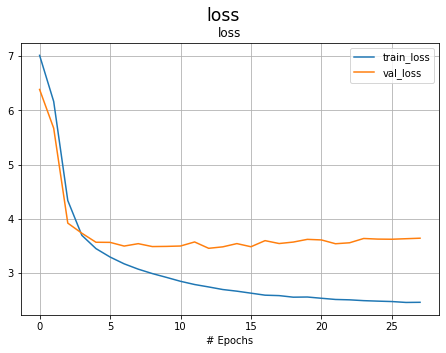

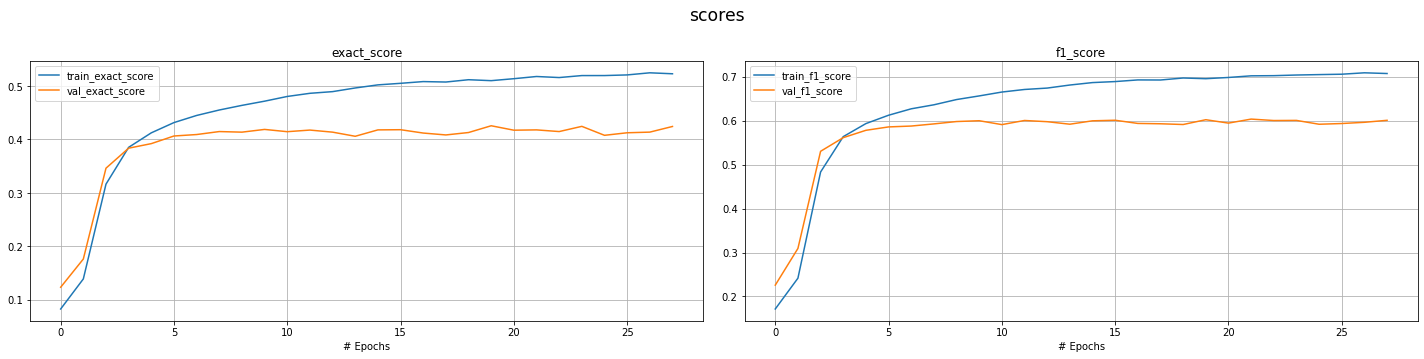

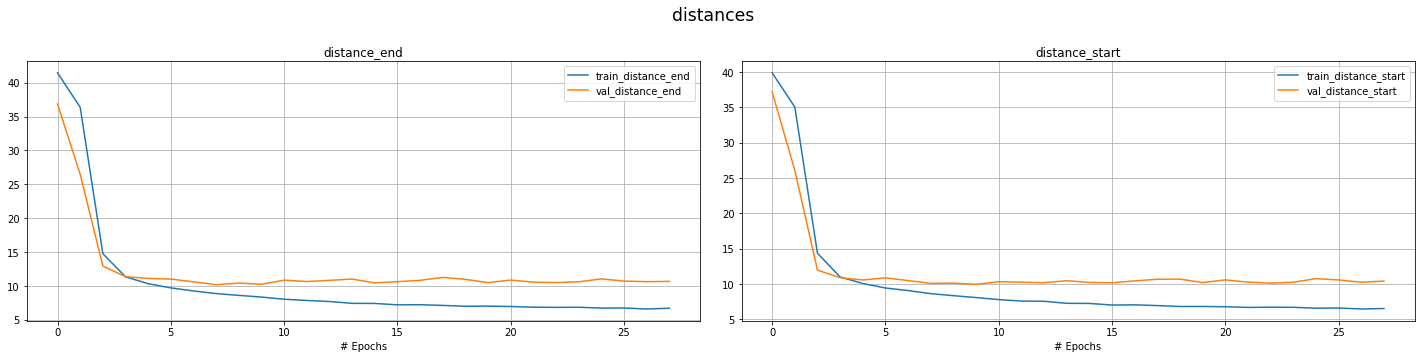

In [20]:
plot_history(history_drop)

In [22]:
torch.save(model_bidaf, "bidaf_last_one.pt")

In [46]:
torch.save(model_bidaf, "bidaf_test.pt")

# to do :

- dropout
- explanation for bad results: BS too small
- our model: trainable embedder = True
- torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
- propose distance as new metric (normalized wrt the number of characters in the context)



our takes 2 hours per epoch

jojonki takes 

